In [1]:
import os
import sys
from os.path import join
import numpy as np
import cv2
import glob
import pandas as pd
from __future__ import division

from matplotlib import cm
from matplotlib import colors

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# Paths
EXP_dir = '../../..'
AOIs_dir = join(EXP_dir, 'Stimuli/AOIs')

### read in list of stim number -> stim name mappings
stimNames = pd.read_csv(join(AOIs_dir, 'AOIstims/stimList.csv'))

### Combine single instances of same AOI
Multiple individuals (in this case, 4) traced the same AOIs on the same image. The first step is to add each individual's drawing for each AOI on top of one another. 

In [3]:
AOIs = ['leftEye', 'rightEye', 'nose', 'mouth']
img = 1

# get the stim filename for this image, read in image data
stim_fname = stimNames.imgName[stimNames.imageIdx==img].values[0]
thisStim = cv2.imread(join(AOIs_dir, 'AOIstims', stim_fname))
stimDims = thisStim.shape

# read in stim
thisStim = cv2.imread(join('AOIstims', stim_fname))

######### Sum all different versions of this AOI
AOIs_summed = {}
for AOI in AOIs:
    # get list of all different versions of this AOI
    searchPattern = join(AOIs_dir, 'raw_AOIs/*_img' + str(img) + '_' + AOI + '.png')
    subjAOIs = glob.glob(searchPattern)

    # make sure at least one match before continuing
    if len(subjAOIs) > 0:
        n_versions = len(subjAOIs)

        # overlay all unique subj drawn AOIs for this AOI
        for i,subjAOI in enumerate(subjAOIs):
            # read in the specific AOI
            thisIm = cv2.imread(subjAOI)

            # convert to grayscale
            thisIm = cv2.cvtColor(thisIm, cv2.COLOR_BGR2GRAY)

            # mask
            thisIm[thisIm > 0] = 1

            # combine
            if i == 0:
                combinedImg = thisIm.copy()
            else:
                combinedImg = combinedImg + thisIm

        # crop combined AOI img to match stim dimensions
        combinedImg = combinedImg[:stimDims[0], :stimDims[1]]

        # write image showing individual subj AOIs overlaid on image
        AOIs_summed[AOI] = combinedImg

#### plot all versions of each AOI overlaid on background image

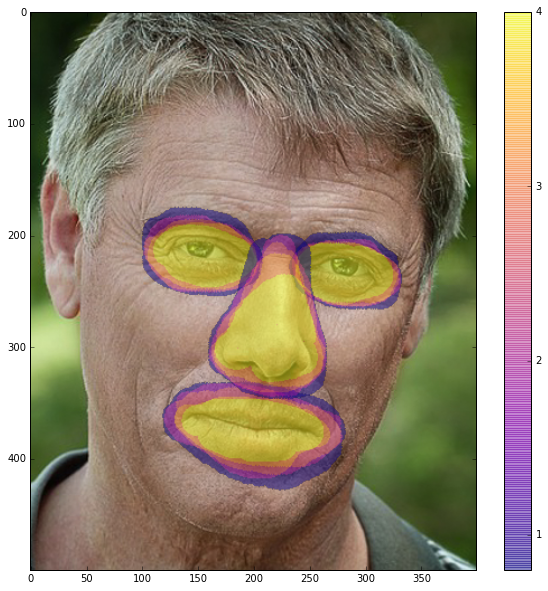

In [4]:
######## Write out reference image for this AOI
# prep background image
thisStim = cv2.imread(join(AOIs_dir, 'AOIstims', stim_fname))
thisStim = cv2.cvtColor(thisStim, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(thisStim)

# add each AOI to the plot
for AOI in AOIs_summed.keys():
    thisAOI = AOIs_summed[AOI]
    scaleFactor = 255/thisAOI.max()
    thisAOI = thisAOI * scaleFactor
    thisAOI[thisAOI == 0] = np.nan

    plt.imshow(thisAOI, cmap='plasma', alpha=.5)
figName = stim_fname.split('.')[0] + '_allAOIs.pdf'
cbar = plt.colorbar(ticks=np.linspace(0,255,5))
cbar.ax.set_yticklabels(['1', '2', '3', '4'])



### Create the composite AOI for each region
In order to consider a pixel as belonging to a certain AOI, at least 2 individuals had to include that pixel in their tracing. This reduces the chances of random missing pixels in the middle of the AOI, as well as increases the validity of the AOI definition.

In [5]:
### remove AOI pixels where less than 2 subjects agreed
for AOI in AOIs_summed.keys():
    AOIs_summed[AOI][AOIs_summed[AOI]<2] = 0

### mask AOIs to remove overlapping pixels
AOIs_summed_new = {}
for AOI1 in AOIs_summed.keys():
    overlay = AOIs_summed[AOI1]
    for AOI2 in AOIs_summed.keys():
        if AOI1 != AOI2:
            underlay = AOIs_summed[AOI2]
            underlay[overlay>=underlay] = 0    # tie goes to the overlay
            AOIs_summed_new[AOI2] = underlay

### assign unique values to each AOI
for AOI in AOIs_summed_new.keys():
    if AOI == 'rightEye':
        AOIs_summed_new[AOI][AOIs_summed_new[AOI]>0] = 1
    elif AOI == 'leftEye':
        AOIs_summed_new[AOI][AOIs_summed_new[AOI]>0] = 2
    elif AOI == 'nose':
        AOIs_summed_new[AOI][AOIs_summed_new[AOI]>0] = 3
    elif AOI == 'mouth':
        AOIs_summed_new[AOI][AOIs_summed_new[AOI]>0] = 4 

rightEye
mouth
leftEye
nose


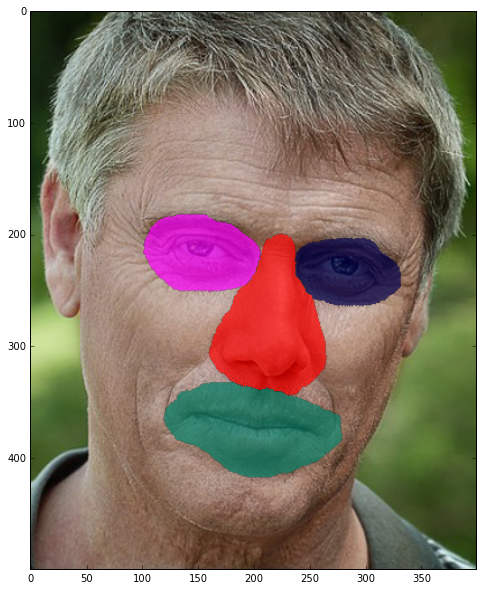

In [6]:
# prep background image
thisStim = cv2.imread(join(AOIs_dir, 'AOIstims', stim_fname))
thisStim = cv2.cvtColor(thisStim, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(thisStim)


colors = [(1, .3, .2), (1, .5, .4), (0, 1, .2), (.2, .4, 1)]
cmap_name = 'AOIcolors'
colors = ['seismic', 'summer', 'spring', 'autumn']


# add each AOI to the plot
for i,AOI in enumerate(AOIs_summed_new.keys()):
    print AOI
    thisAOI = AOIs_summed_new[AOI]
    scaleFactor = 255/4
    thisAOI = thisAOI * scaleFactor
    thisAOI[thisAOI == 0] = np.nan

    plt.imshow(thisAOI, cmap=colors[i], alpha=.7)

### The last step (not shown) is to rescale the AOI labels to be [0,255] and save as output png file